# UBC Ovarian Cancer Subtype Classification and Outlier Detection

In [1]:
try:   
    import numpy as np
    import pandas as pd
    import cv2
    import matplotlib.pyplot as plt
    import seaborn as sns
    import re
    import os
    import warnings
    import shutil
    from skimage import io, color
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVC
    from sklearn import metrics
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from imblearn.combine import SMOTEENN
    from imblearn.over_sampling import SMOTE
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications import ResNet50V2
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras import layers, models, optimizers
    from PIL import Image

    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning, message=".*low contrast image.*")
except ImportError as import_error:
    print(f"Import Error: {import_error}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data exploration and analysis

In [2]:
try:    
    path_to_data = '/kaggle/input/UBC-OCEAN/'
    df = pd.read_csv(path_to_data + 'train.csv')

    print("Dataset Overview:")
    print(df.info())

    print("\nSummary Statistics:")
    print(df.describe())

    print("\nMissing Values:")
    print(df.isnull().sum())
    
except Exception as data_exploration_error:
    print(f"Data Exploration Error: {data_exploration_error}")

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      538 non-null    int64 
 1   label         538 non-null    object
 2   image_width   538 non-null    int64 
 3   image_height  538 non-null    int64 
 4   is_tma        538 non-null    bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 17.5+ KB
None

Summary Statistics:
           image_id    image_width  image_height
count    538.000000     538.000000    538.000000
mean   32194.340149   48859.533457  29729.460967
std    18774.950592   20040.989927  10762.899796
min        4.000000    2964.000000   2964.000000
25%    15881.250000   34509.000000  22089.500000
50%    32152.000000   48160.000000  29732.000000
75%    47892.500000   64143.750000  37880.750000
max    65533.000000  105763.000000  50155.000000

Missing Values:
image_id        0
label           0
imag

### Class distribution

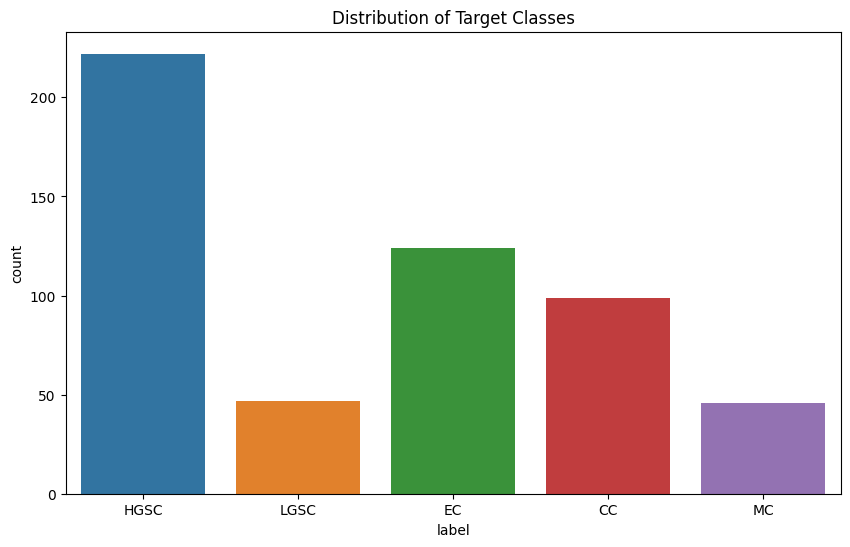

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Classes')
plt.show()

### Distribution of image dimentions

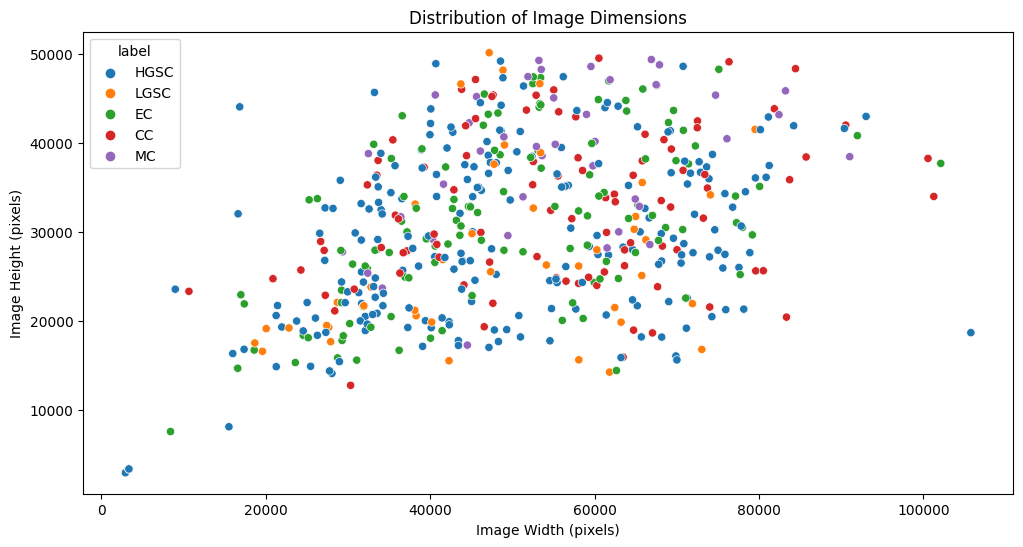

In [4]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='image_width', y='image_height', hue='label', data=df)
plt.title('Distribution of Image Dimensions')
plt.xlabel('Image Width (pixels)')
plt.ylabel('Image Height (pixels)')
plt.show()

### TMA

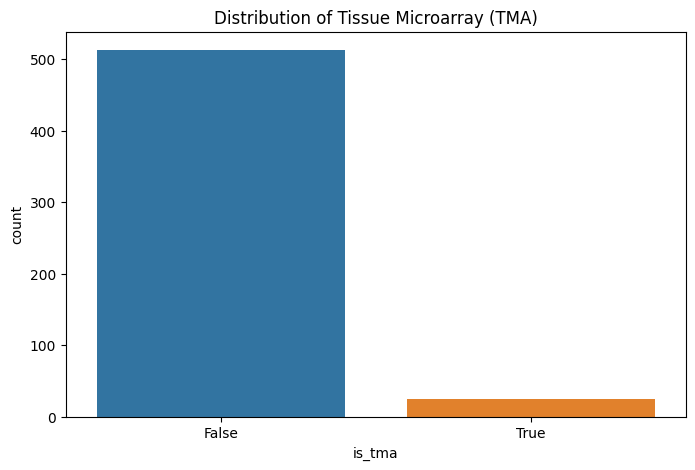

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(x='is_tma', data=df)
plt.title('Distribution of Tissue Microarray (TMA)')
plt.show()

### Samples

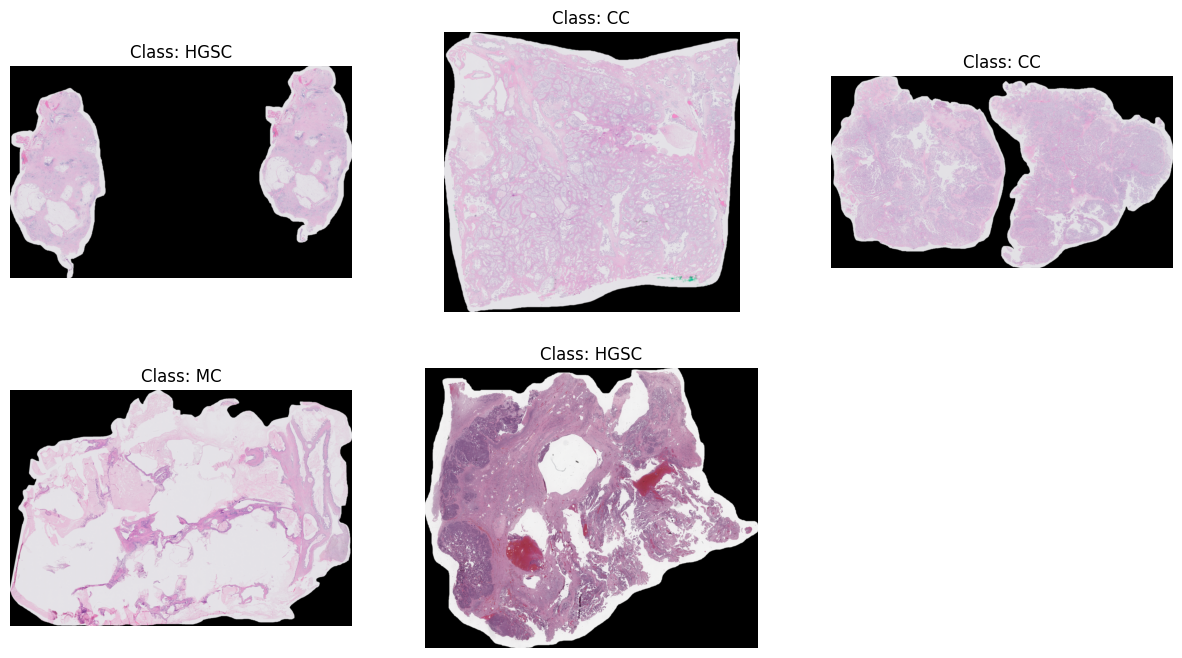

In [6]:
sample_images = df.sample(5)
plt.figure(figsize=(15, 8))
for i, (_, row) in enumerate(sample_images.iterrows(), 1):
    plt.subplot(2, 3, i)
   
    img_path = path_to_data + f'train_thumbnails/{row["image_id"]}_thumbnail.png'
    if os.path.exists(img_path):
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f'Class: {row["label"]}')
        plt.axis('off')
plt.show()

## Image tiling

In [7]:
# not recommended
Image.MAX_IMAGE_PIXELS = None

Defining a fuction to tile the image with overlap, eliminate black images and generate a new csv file for labeling :


In [8]:
def tile_generator(image_path, tile_size, overlap, label, black_threshold=70):
    image = io.imread(image_path)
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    # tile the image with overlap
    step_size = int(tile_size * (1 - overlap))
    for i in range(0, image.shape[0] - tile_size + 1, step_size):
        for j in range(0, image.shape[1] - tile_size + 1, step_size):
            tile = image[i:i+tile_size, j:j+tile_size, :]

            # eliminate black images
            grayscale_tile = color.rgb2gray(tile)
            black_percentage = (grayscale_tile < 0.5).sum() / grayscale_tile.size * 100

            if black_percentage < black_threshold:
                tile_filename = f'{image_name}_tile_{i}_{j}.png'
                yield tile, label, tile_filename

In [9]:
def tile_and_save(image_path, tile_size, overlap, output_dir, label, csv_output_path, black_threshold=70):
    generator = tile_generator(image_path, tile_size, overlap, label, black_threshold)
    
    csv_data = []

    for idx, (tile, label, tile_filename) in enumerate(generator):
        tile_filename = os.path.join(output_dir, tile_filename)
        io.imsave(tile_filename, tile)
        csv_data.append([tile_filename, label])

    # save the csv file
    csv_df = pd.DataFrame(csv_data, columns=["tile_path", "label"])
    csv_df.to_csv(csv_output_path, mode='a', header=not os.path.exists(csv_output_path), index=False)

Actula tiling

*modify directory paths as needed*

In [10]:
# set parameters
images_directory = "/kaggle/input/UBC-OCEAN/train_thumbnails" # "/kaggle/input/UBC-OCEAN/train_images" 
output_directory = "/kaggle/working/tiles"

# clear output directory or create it if it doesn't exsist
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# csv file, create if it doesn't exsist
csv_output_path = "/kaggle/working/tiles_labels.csv"
if os.path.exists(csv_output_path):
    with open(csv_output_path, 'w') as file:
        # Write an empty string to clear the content
        file.write("")
    columns=["tile_path", "label"]
    df = pd.DataFrame(columns=columns)
    df.to_csv(csv_output_path, index=False)
    
if not os.path.exists(csv_output_path):
    columns=["tile_path", "label"]
    df = pd.DataFrame(columns=columns)
    df.to_csv(csv_output_path, index=False)
    
# tiling parameters
tile_size = 224 
overlap = 0.2
data = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv") 


# go through train.csv and tile each image
try:
    for index, row in data.iterrows():
        image_id = row["image_id"]
        label = row["label"]
        image_path = os.path.join(images_directory, f"{image_id}_thumbnail.png") # change to "{image_id}.png" ?
        try:
            if os.path.exists(image_path):
                tile_and_save(image_path, tile_size, overlap, output_directory, label, csv_output_path)
            print(f"LOG: image : {image_id}, has been tiled!")
        except Exception as tile_exception:
            print(f"Error while tiling image {image_id}: {tile_exception}")
        # end loop early for testing, delete line below 
        if(index == 5): break # ONLY x IMAGES
except Exception as tiling_error:
    print(f"Tiling Error: {tiling_error}")    
# display head of new csv file 
new_csv_data = pd.read_csv(csv_output_path)
print("NEW CSV FILE CREATED : ")
print(new_csv_data.head())


LOG: image : 4, has been tiled!
LOG: image : 66, has been tiled!
LOG: image : 91, has been tiled!
LOG: image : 281, has been tiled!
LOG: image : 286, has been tiled!
LOG: image : 431, has been tiled!
NEW CSV FILE CREATED : 
                                           tile_path label
0   /kaggle/working/tiles/4_thumbnail_tile_0_179.png  HGSC
1   /kaggle/working/tiles/4_thumbnail_tile_0_895.png  HGSC
2  /kaggle/working/tiles/4_thumbnail_tile_0_1074.png  HGSC
3  /kaggle/working/tiles/4_thumbnail_tile_0_1253.png  HGSC
4  /kaggle/working/tiles/4_thumbnail_tile_0_1432.png  HGSC


### Display examples

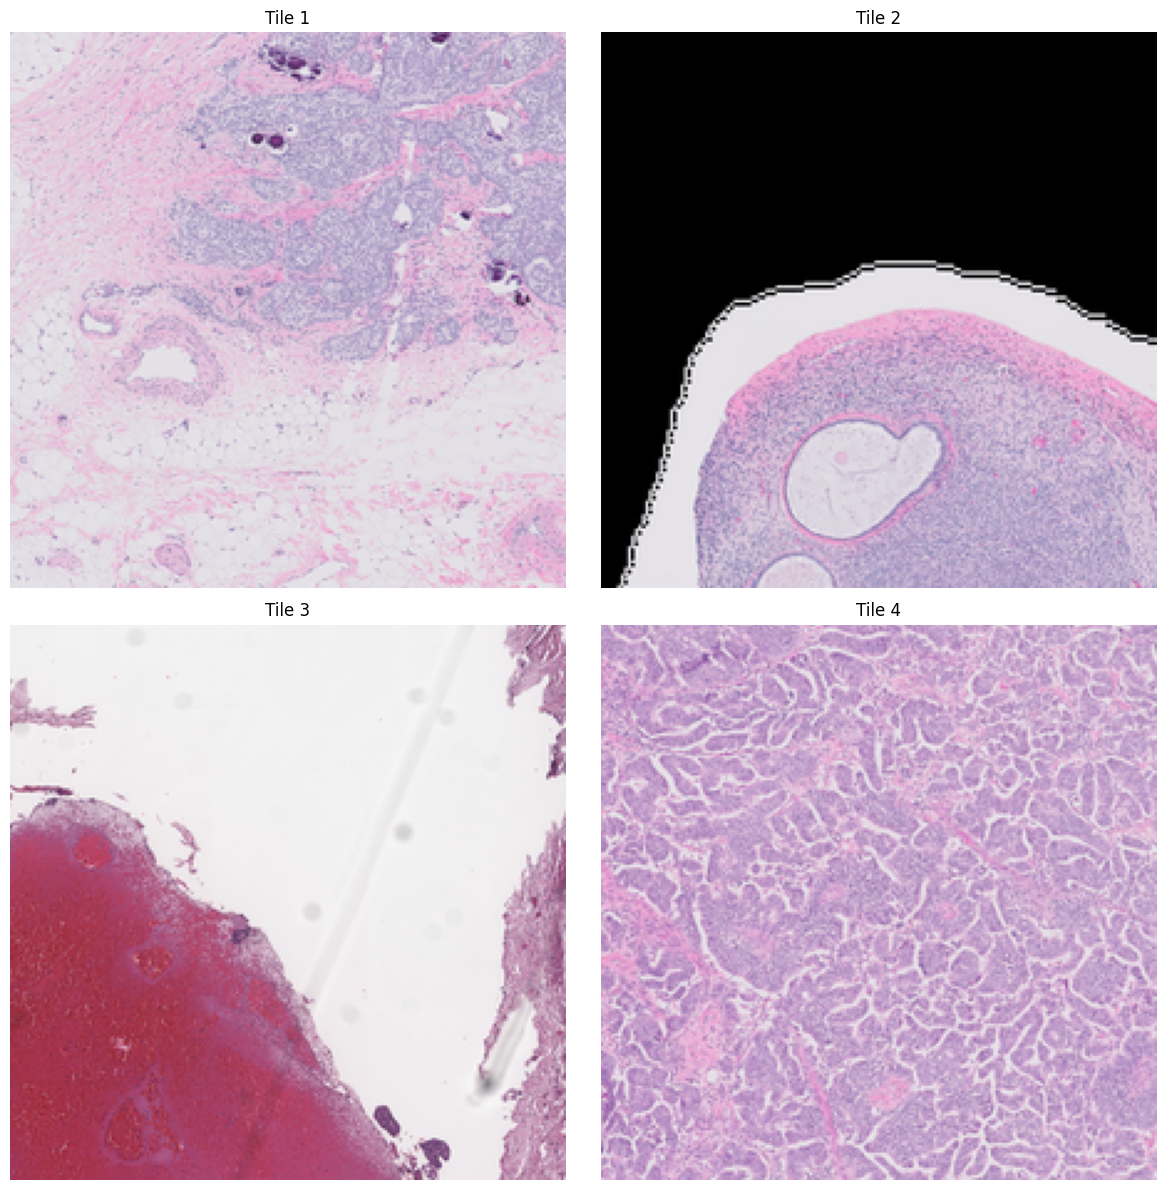

In [11]:
# displaying some of the tiles 
output_directory = "/kaggle/working/tiles"

num_displayed_tiles = 4
num_rows = (num_displayed_tiles + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 12))

# list of image files in the directory
image_files = [f for f in os.listdir(output_directory) if f.endswith('.png')]

for i in range(num_displayed_tiles):
    if i < len(image_files):
        tile_filename = os.path.join(output_directory, image_files[i])
        tile = io.imread(tile_filename)
        plt.subplot(num_rows, num_cols, i + 1)  
        plt.imshow(tile)
        plt.axis('off')
        plt.title(f'Tile {i + 1}')
    else:
        # display an empty plot, if there are less then 4 images
        plt.subplot(num_rows, num_cols, i + 1)
        plt.axis('off')

plt.tight_layout()
plt.show()

#### Class distribution check

In [12]:
tiles_labels_df = pd.read_csv("/kaggle/working/tiles_labels.csv")
class_counts = tiles_labels_df['label'].value_counts()
print(class_counts)

label
HGSC    342
LGSC    213
EC      151
Name: count, dtype: int64


## Data preparation


### Load and Preprocess Data

In [13]:
tiles_labels_df = pd.read_csv("/kaggle/working/tiles_labels.csv")

# Pixel normalization
X_images = [cv2.imread(img_path) / 255.0 for img_path in tiles_labels_df['tile_path']]
X_images = np.array(X_images)
y_labels = tiles_labels_df['label']

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_images, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [14]:
unique_values1 = np.unique(y_encoded)
print("Unique values in y_encoded:", unique_values1)
unique_values2 = np.unique(y_labels)
print("correspond to:", unique_values2)

Unique values in y_encoded: [0 1 2]
correspond to: ['EC' 'HGSC' 'LGSC']


**Before using SMOTE :**

In [15]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)

print("Number of different classes:", len(unique_classes))
print("Instances for each class:")
for class_label, count in zip(unique_classes, class_counts):
    print(f"Class {class_label}: {count} instances")

max_num_samples = np.max(class_counts)
print(f"max num of samples = {max_num_samples}")

Number of different classes: 3
Instances for each class:
Class 0: 121 instances
Class 1: 273 instances
Class 2: 170 instances
max num of samples = 273


In [16]:
# Oversampling with SMOTE
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flattened, y_train)

# Reshape back to the original format
X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)

**After using SMOTE :**

In [17]:
unique_classes1, class_counts1 = np.unique(y_train_resampled, return_counts=True)

print("Number of different classes:", len(unique_classes1))
print("Instances for each class:")
for class_label, count in zip(unique_classes1, class_counts1):
    print(f"Class {class_label}: {count} instances")


Number of different classes: 3
Instances for each class:
Class 0: 273 instances
Class 1: 273 instances
Class 2: 273 instances


#### Delete unnecessary variables

In [18]:
del X_images, y_labels, df

### Data augmentation

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train_resampled)

augmented_images_per_original = 2
augmented_data = []
for X_batch, y_batch in train_datagen.flow(
    X_train_resampled, y_train_resampled, batch_size=augmented_images_per_original
):
    augmented_data.append((X_batch, y_batch))
    if len(augmented_data) >= len(X_train_resampled):
        break

X_train_augmented = np.concatenate([X_train_resampled] + [data[0] for data in augmented_data])
y_train_augmented = np.concatenate([y_train_resampled] * (augmented_images_per_original + 1))

augmented_indices = np.arange(len(X_train_augmented))
np.random.shuffle(augmented_indices)
X_train_augmented = X_train_augmented[augmented_indices]
y_train_augmented = y_train_augmented[augmented_indices]

## ResNet

In [20]:
weights_path = '/kaggle/input/weights/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = ResNet50V2(
    include_top=False, weights=weights_path, input_shape=(224, 224, 3)
)

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(unique_classes), activation='softmax') 
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train_generator = train_datagen.flow(X_train_augmented, y_train_augmented, batch_size=16)



In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
try:
    model.fit(
        train_generator,
        epochs=2, #100
        validation_data=(X_test, y_test),
        # callbacks=[early_stopping],
        verbose=1
    )
except Exception as model_training_error:
    print(f"Model Training Error: {model_training_error}")

Epoch 1/2
154/154 [==============================] - 79s 207ms/step - loss: 1.1111 - accuracy: 0.3884 - val_loss: 2.6996 - val_accuracy: 0.4930
Epoch 2/2
154/154 [==============================] - 27s 176ms/step - loss: 1.0713 - accuracy: 0.4084 - val_loss: 489.3583 - val_accuracy: 0.4789


### Preparing test data

In [22]:
def get_number_from_filename(filename):
    match = re.match(r'^(\d+)_', filename)
    if match:
        return int(match.group(1))
    else:
        return None

image_dir_test = '/kaggle/input/UBC-OCEAN/test_thumbnails'
images_test = []
numbers_test = []

image_files = [f for f in os.listdir(image_dir_test) if os.path.isfile(os.path.join(image_dir_test, f))]
try:
    for image_file in image_files:
        try:
            image_path = os.path.join(image_dir_test, image_file)
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))
            img_array = np.array(img)
            number = get_number_from_filename(image_file)

            images_test.append(img_array)
            numbers_test.append(number)

        except Exception as e:
            print(f"An error occurred treating the file : {image_file}: {str(e)}")
except Exception as test_data_prep_error:
    print(f"Test Data Preparation Error: {test_data_prep_error}")
    
X_test = np.array(images_test)
X_test_normalized = X_test / 255.0

### Prediction

In [23]:
# Model Prediction
y_pred = model.predict(X_test_normalized)
y_pred_categories = label_encoder.inverse_transform([np.argmax(y) for y in y_pred])

1/1 [==============================] - 2s 2s/step


### Submission

In [24]:
# Create Submission DataFrame
submission_df = pd.DataFrame(
    {'image_id': numbers_test, 'label': y_pred_categories},
    columns=['image_id', 'label']
)

# Save Submission CSV
submission_df.to_csv('/kaggle/working/submission.csv', index=False)